In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [88]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

cols = ['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality',
       'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt',
       'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
       'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
       'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


In [98]:
## Preprocessing

def one_hot_jet_num(tX, idx=-1):
 
    #extract the jet_num column
    one_hot = tX[:,idx].astype(int)
    jet_num = np.zeros((tX.shape[0], 4))
    
    #create one column for each possible valur of jet_num
    jet_num[np.where(one_hot == 0),0] = 1
    jet_num[np.where(one_hot == 1),1] = 1
    jet_num[np.where(one_hot == 2),2] = 1
    jet_num[np.where(one_hot == 3),3] = 1

    #create empty array to contain the  new values 
    tX_hot = np.empty((tX.shape[0], 30+3))
    
    #fill the new array without jet_num
    tX_hot[:,:-4] = tX[:,:-1]

    #add the 4 news columns
    tX_hot[:,[-4,-3,-2,-1]] = jet_num
    return tX_hot

""" -- Data cleaning -- """

def nan_to_mean(x):
    '''Set NaN values to the value of the mean for each feature'''
    
    x[x == -999] = np.nan
    col_mean = np.nanmean(x, axis=0)
    inds = np.where(np.isnan(x))
    x[inds] = np.take(col_mean, inds[1])
    
    return x

def nan_to_zero(x):
    '''Set NaN values to the value of the mean for each feature'''
    
    x[x == -999] = np.nan
    x[np.isnan(x)] = 0    
    return x

def nan_to_medi(x):
    '''Set NaN values to the value of the mean for each feature'''
    
    x[x == -999] = np.nan
    col_median = np.nanmedian(x, axis=0)
    inds = np.where(np.isnan(x))
    x[inds] = np.take(col_median, inds[1])
    return x

def cross_validation_logreg(y, x, k_indices, k, gamma, steps):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    #starting with random weights
    w = np.random.rand(x_train.shape[1],)
    for step in range(steps):
        loss, w = learning_by_gradient_descent(y_train, x_train, w, gamma)
    loss_tr = compute_mse(y_train,x_train,w)
    loss_te = compute_mse(y_test ,x_test ,w)
    
    return loss_tr, loss_te, w

In [89]:
from implementations import *

#move jet_num to the last position
tX.T[[22,-1]] = tX.T[[-1,22]]
tX[tX == -999] = np.nan
print(tX[1,-3:])

tX = cols_log_transform(tX)
print(tX[1,-3:])
deg = 2

tX_ = np.zeros([tX.shape[0], (tX.shape[1]-1)*deg +2])
tX_[:,:-1] = build_poly(tX[:,:-1],2)
tX_[:,-1] = tX[:,-1]

tX_[:,1:-1] = normalize_data_std(tX_[:,1:-1])
print(tX_[1,-3:])
tX_md = np.ndarray.copy(tX_)
tX_me = np.ndarray.copy(tX_)
tX_ze = np.ndarray.copy(tX_)

[nan nan  1.]
[nan nan  1.]
[nan nan  1.]


In [90]:
print(nan_to_medi(tX_md)[1,-3:])
print(nan_to_mean(tX_me)[1,-3:])
print(nan_to_zero(tX_ze)[1,-3:])

[-0.35958576 -0.27819319  1.        ]
[-1.41613605e-14 -2.24237748e-14  1.00000000e+00]
[0. 0. 1.]


In [96]:
np.logspace(-2,0,3)

array([0.01, 0.1 , 1.  ])

In [ ]:
seed = 8463527
k_fold = 4
gammas = np.logspace(-2,0,3)
steps=3000

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr_md = []
rmse_te_md = []
rmse_tr_ma = []
rmse_te_ma = []
rmse_tr_ze = []
rmse_te_ze = []

ws_md = []
ws_ma = []
ws_ze = []

#for lambda_ in lambdas:
for gamma in gammas:
    rmse_tr_tmp_md = []
    rmse_te_tmp_md = []
    rmse_tr_tmp_ma = []
    rmse_te_tmp_ma = []
    rmse_tr_tmp_ze = []
    rmse_te_tmp_ze = []
    for k in range(k_fold):
        loss_tr_md, loss_te_md, w_md = cross_validation_logreg(y, tX_md, k_indices, k, gamma, steps)
        loss_tr_ma, loss_te_ma, w_ma = cross_validation_logreg(y, tX_me, k_indices, k, gamma, steps)
        loss_tr_ze, loss_te_ze, w_ze = cross_validation_logreg(y, tX_ze, k_indices, k, gamma, steps)

        rmse_tr_tmp_md.append(loss_tr_md)
        rmse_te_tmp_md.append(loss_te_md)
        rmse_tr_tmp_ma.append(loss_tr_ma)
        rmse_te_tmp_ma.append(loss_te_ma)
        rmse_tr_tmp_ze.append(loss_tr_ze)
        rmse_te_tmp_ze.append(loss_te_ze)
    ws_md.append(w_md)
    ws_ma.append(w_ma)
    ws_ze.append(w_ze)
    #combine the loss over the folds
    rmse_tr_md.append(np.mean(rmse_tr_tmp_md))
    rmse_te_md.append(np.mean(rmse_te_tmp_md))
    rmse_tr_ma.append(np.mean(rmse_tr_tmp_ma))
    rmse_te_ma.append(np.mean(rmse_te_tmp_ma))
    rmse_tr_ze.append(np.mean(rmse_tr_tmp_ze))
    rmse_te_ze.append(np.mean(rmse_te_tmp_ze))

/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:218: RuntimeWarning: overflow encountered in exp
  s = 1.0/(1.0 + np.exp(-t))


In [ ]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.plot(gammas, rmse_te, "-" , label="1")
ax1.plot(gammas, rmse_tr, "--", label="2")


plt.xlabel("gamma")
plt.ylabel("error")
plt.yscale("log")
plt.legend()
plt.show()

In [6]:
w0 = np.random.rand(tX_2.shape[1])

[[1.5376   6.125625 4.      ]
 [0.       0.       1.      ]
 [0.       0.       1.      ]
 ...
 [0.       0.       1.      ]
 [0.       0.       0.      ]
 [0.       0.       0.      ]]


In [18]:
from implementations import *
seed = 746183561
gamma = 0.01
steps = 8000
ratio = .8

#preprocessing specific to log regression
y[np.where(y == -1)] = 0

#tX_hot_2 = build_poly(tX_hot,2)

#losses_ = []
#losses_m = []
losses_z = []

#using last run weights
#w = weights
#random starting weights
#w = np.random.rand(tX_2.shape[1])
w_tx = w0
w_me = w0
w_ze = w0

#ws_ = []
#ws_m = []
ws_z = []

for step in range(steps):
    #loss, w_tx = learning_by_gradient_descent(y, tX_2, w_tx, gamma)
    #losses_.append(loss)
    #loss, w_me = learning_by_gradient_descent(y, tX_mean_2, w_me, gamma)
    #losses_m.append(loss)
    loss, w_ze = learning_by_gradient_descent(y, tX_zero_2, w_ze, gamma)
    losses_z.append(loss)

    ws_.append(w_tx)
    ws_m.append(w_me)
    ws_z.append(w_ze)

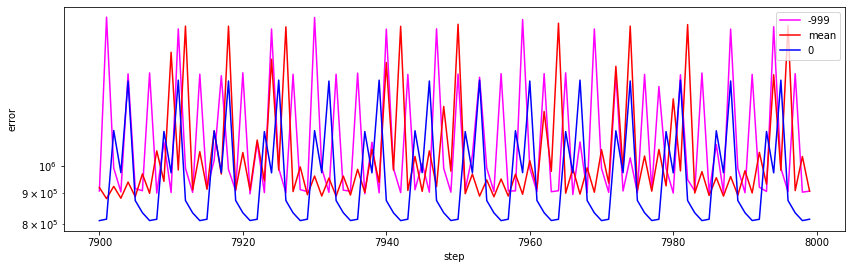

In [19]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.plot(range(steps)[-100:], losses_[-100:], 'magenta', label="-999")
ax1.plot(range(steps)[-100:], losses_m[-100:], 'red', label="mean")
ax1.plot(range(steps)[-100:], losses_z[-100:], 'blue', label="0")

#ax1.plot(range(steps), losses_te, 'brown', label="rmse_te_deg1")

plt.xlabel("step")
plt.ylabel("error")
plt.yscale("log")

plt.legend()
plt.show()

In [24]:
mse_  = [compute_mse(y, tX, w) for w in ws_]
mse_m = [compute_mse(y, tX_mean, w) for w in ws_m]
mse_z = [compute_mse(y, tX_zero, w) for w in ws_z]

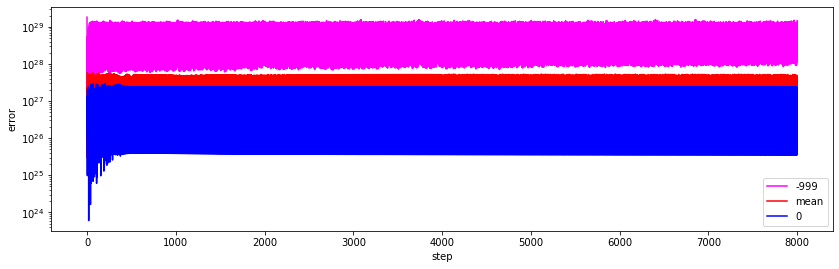

In [38]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.plot(range(steps), mse_[:8000], 'magenta', label="-999")
ax1.plot(range(steps), mse_m[:8000], 'red', label="mean")
ax1.plot(range(steps), mse_z[:8000], 'blue', label="0")

#ax1.plot(range(steps), losses_te, 'brown', label="rmse_te_deg1")

plt.xlabel("step")
plt.ylabel("error")
plt.yscale("log")

plt.legend()
plt.show()

In [43]:
print(min(mse_))
print(min(mse_m))
print(min(mse_z))

54059609325.65468
54059609325.65468
6.024303373125174e+23


In [44]:
print(mse_.index(54059609325.65468))
print(mse_m.index(54059609325.65468))
print(mse_z.index(6.024303373125174e+23))

8000
8000
19


## Least_squares_DG

## Least_squares_SDG
Ne donne que des loss = nan, le calcul du gradient ne se passe pas bien, que ça soit avec les rows contenant du -999 ou pas.

## Least_square
degree 1 -> -334.4 (mse loss)

## Ridge_regression
Seems the most suited since we have so many features. Maybe we could remove some features if they are highly correlated (might be visible on plots?
degree = 6 -> singular matrix

## Logistic_regression
Since we have a binary output, it might be the best option...

## Reg_logistic_regression

# Remarks
if degree = 3, 7, ...
-> LinAlgError: Singular matrix



# TODO
- plot all the variable with boxplot
- compute ,np.cov between the variables
- compute Pearson correlation np.cov(x,y)/(std(x) * std(y))

In [ ]:
def predict_labels(w, x):
    return 1

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '/home/toinou/course/ml/ml_proj1/data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '/home/toinou/course/ml/ml_proj1/sub11.csv'
tX_test.T[[22, -1]] = tX_test.T[[-1, 22]]
tX_test_hot = one_hot_jet_num(nan_to_mean(tX_test))
tX_test_hot_2 = build_poly(tX_test_hot,2)
y_pred = predict_labels(weights, tX_test_hot_2)
y_pred[np.where(y_pred == 0)] = -1
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

## Submissions

1. ridge, degree 2, lambdas = 0.75 -> 0.752
2. ridge, degree 1, lambdas = 0.75 -> 0.732
3. logreg, degree 1, lambda = 0.75 -> 0.662

implementation of normalization and hot one

4. ridge, degree 1, lambdas 0.69 -> 0.752
5. ridge, degree 2, lambdas 0.69 -> 0.732
6. logreg, degree 1, gamma ?     -> (random start, 3000 steps)
7. logreg, degree 1, gamma 1.5   -> 0.696 (random start, one hot, 8000 steps)
8. logreg, degree 1, gamma 1     -> 0.695 (random start, one hot, 8000 steps)
9. logreg, degree 2, gamma 1.5   -> 0.765 (random start, one hot, 8000 steps)
10. logreg, degree 3, gamma 1.5   -> 0.660 (random start, one hot, 12000 steps)

In [ ]:
np.array([0,2,1,2,3,4,1,2])+10**-5